In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from calendar import c
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/焦化厂利润.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet = sheet.rename(columns={'现货焦化利润/港口模拟/即期': '焦化厂利润'})
last_day = sheet['焦化厂利润'].last_valid_index()     

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet

In [5]:
'''
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值_全量']],
    on='Date',
    how='left'
)
sheet_daily['中国10年期国债收益率Non-Trend/F0.2'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].fillna(sheet_daily['预测值_全量'])
sheet_daily = sheet_daily.drop(columns=['预测值_全量'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
'''

"\n# 合并 sheet1 和 sheet2 的数据到 sheet\nsheet_daily = sheet.copy()\nsheet_daily.index.name = 'Date'\nsheet_daily = sheet_daily.reset_index()\n\n# 合并 sheet1 的美国10年通胀预期数据\nsheet_daily = pd.merge(\n    sheet_daily,\n    sheet1[['Date', '预测值_全量']],\n    on='Date',\n    how='left'\n)\nsheet_daily['中国10年期国债收益率Non-Trend/F0.2'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].fillna(sheet_daily['预测值_全量'])\nsheet_daily = sheet_daily.drop(columns=['预测值_全量'])\n\n# 将 sheet_daily 重新赋值给 sheet\nsheet = sheet_daily.copy()\nsheet = sheet.set_index('Date')\n"

In [6]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['主焦煤价格/临汾'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()   

,Date,主焦煤价格/临汾_预测
4,2025-11-01,1600.000000
3,2025-11-07,1827.613798
2,2025-11-14,1781.418226
1,2025-11-21,1722.671858
0,2025-11-28,1746.186715


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '主焦煤价格/临汾_预测']],
    on='Date',
    how='left'
)
sheet_daily['主焦煤价格/临汾'] = sheet_daily['主焦煤价格/临汾'].fillna(sheet_daily['主焦煤价格/临汾_预测'])
sheet_daily = sheet_daily.drop(columns=['主焦煤价格/临汾_预测'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [8]:
sheet.columns

Index(['焦化厂利润', '主焦煤价格/临汾', '螺纹利润率', '钢铁PMI', '全国主要钢企高炉开工率', '螺纹期货价格',
       '焦炭库存天数（钢厂/247家）', '焦炭基差率/20DMA', '螺纹高炉利润/上海/即期/14DMA', '螺纹盘面利润',
       '螺纹高炉利润/上海/即期'],
      dtype='object')

In [9]:
################################# 处理缺失值 #################################
fill_methods = { 
'主焦煤价格/临汾':'interpolate',
'螺纹利润率':'interpolate',
'钢铁PMI':'interpolate',
'全国主要钢企高炉开工率':'interpolate',
'螺纹期货价格':'interpolate',
'焦炭库存天数（钢厂/247家）':'interpolate',
'焦炭基差率/20DMA':'interpolate',
'螺纹高炉利润/上海/即期/14DMA':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)

#################################  因子处理  #################################
# 将日度数据转换为周度数据
# 首先创建临时DataFrame用于周度转换
temp_df = sheet.copy()
temp_df.index = pd.to_datetime(temp_df.index)

 # 使用7天滚动窗口平滑数据
#sheet['澳煤和蒙煤仓单价基差'] = temp_df['澳煤和蒙煤仓单价基差'].rolling(window=7, min_periods=1).mean()


sheet['螺纹利润率_提前80天'] = sheet['螺纹利润率'].shift(30)   
sheet['钢铁PMI_提前20天'] = sheet['钢铁PMI'].shift(20)
sheet['全国主要钢企高炉开工率_提前20天'] = sheet['全国主要钢企高炉开工率'].shift(20)      
sheet['螺纹期货价格_提前50天'] = sheet['螺纹期货价格'].shift(50)
sheet['焦炭库存天数（钢厂/247家）_提前20天'] = sheet['焦炭库存天数（钢厂/247家）'].shift(20)   
sheet['焦炭基差率/20DMA_提前20天'] = sheet['焦炭基差率/20DMA'].shift(20)    
sheet['螺纹高炉利润/上海/即期_提前20天'] = sheet['螺纹高炉利润/上海/即期'].shift(20)
sheet['螺纹盘面利润_提前20天'] = sheet['螺纹盘面利润'].shift(20)

sheet['螺纹期货价格_提前50天_逆序'] = reverse_column(sheet, '螺纹期货价格_提前50天')    
sheet['焦炭库存天数（钢厂/247家）_提前20天_逆序'] = reverse_column(sheet, '焦炭库存天数（钢厂/247家）_提前20天')       
sheet['焦炭基差率/20DMA_提前20天_逆序'] = reverse_column(sheet, '焦炭基差率/20DMA_提前20天') 
sheet['主焦煤价格/临汾_逆序'] = reverse_column(sheet, '主焦煤价格/临汾') 




################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2021-04-17')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['焦化厂利润'].notna())   
]

################################# 数据 读取-处理 结束 #################################

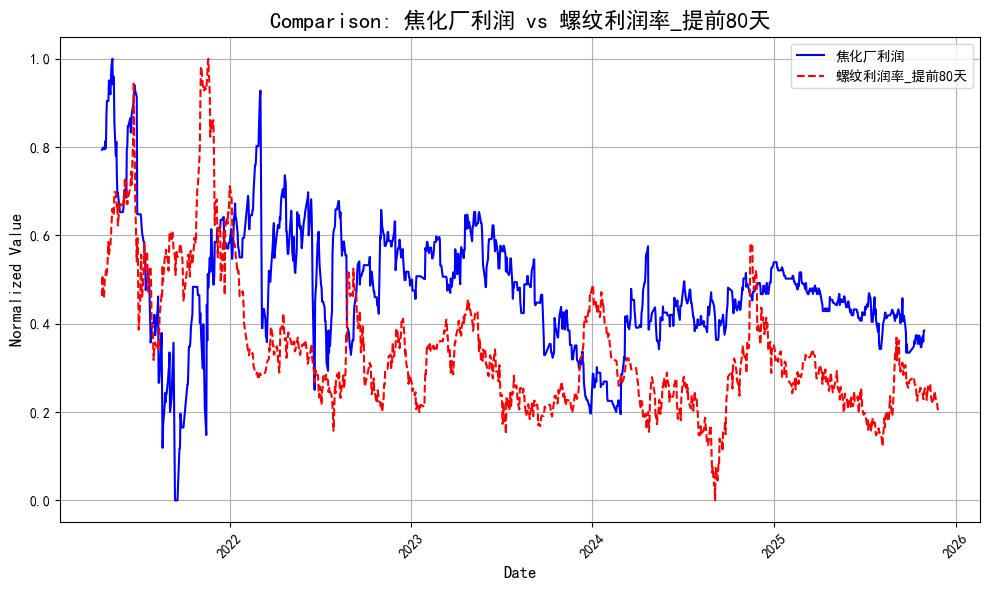

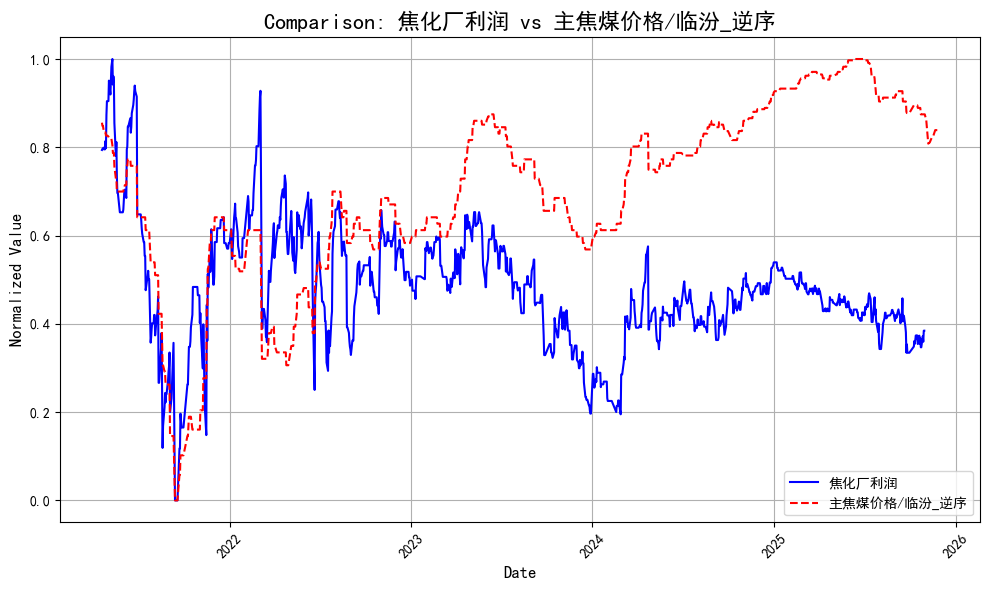

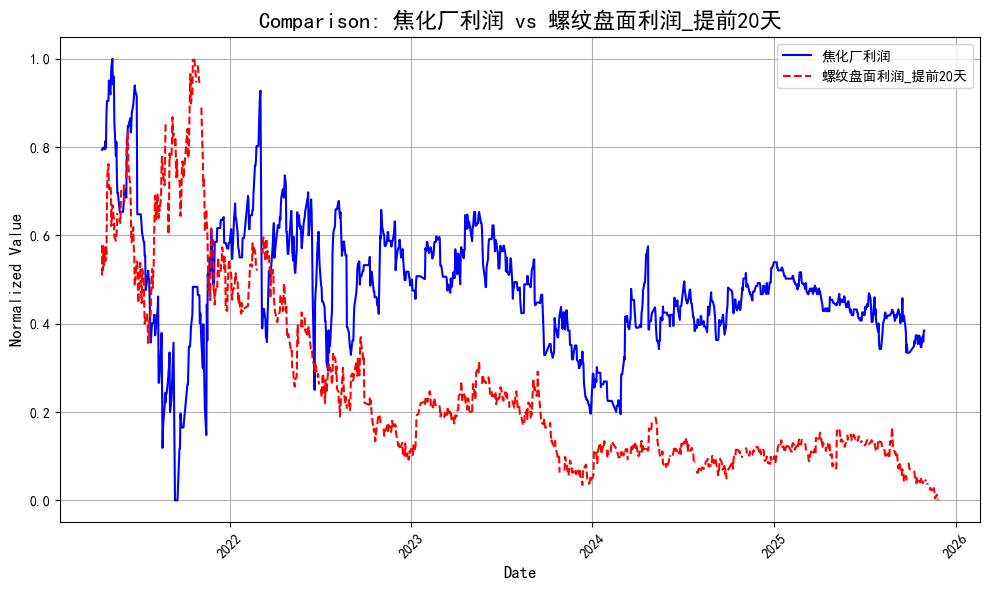

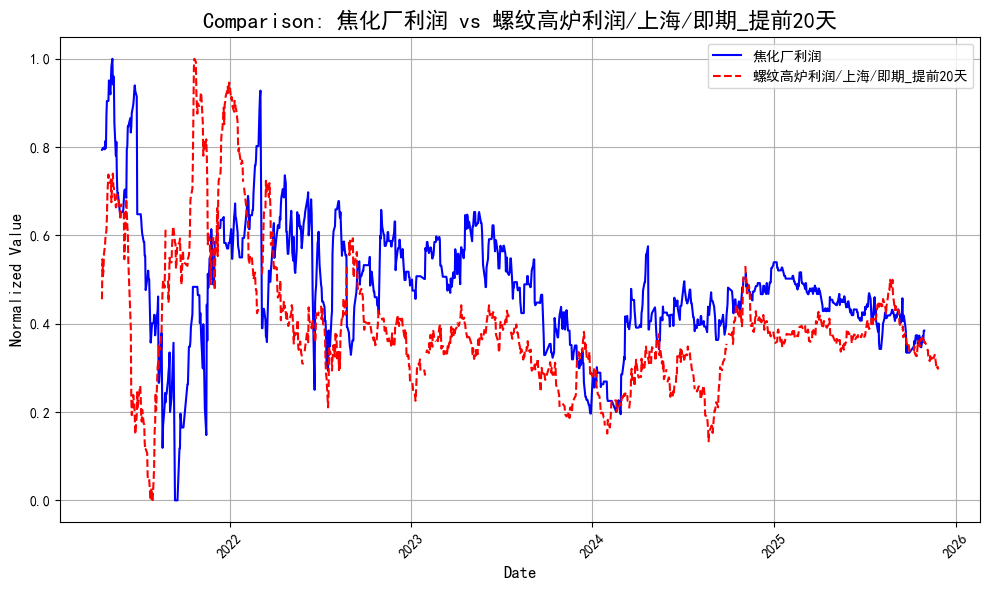

In [10]:
sheet_daily_plot = sheet_daily.set_index('Date')
sheet_daily_plot = sheet_daily_plot['2020':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='焦化厂利润', 
    compare_cols=[
        '螺纹利润率_提前80天',  
        '主焦煤价格/临汾_逆序',
        '螺纹盘面利润_提前20天',
        '螺纹高炉利润/上海/即期_提前20天'
      

        ]
)

In [11]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '螺纹利润率_提前80天',  
        '主焦煤价格/临汾_逆序',
        '螺纹盘面利润_提前20天',
        '螺纹高炉利润/上海/即期_提前20天'
]

predict_column = '焦化厂利润'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth':12,  # 控制树的深度防止过拟合
    'min_child_weight': 1,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.7,  # 特征随机采样
    'gamma': 0,  # 控制分裂
    'reg_alpha': 0,  # L1正则化
    'reg_lambda': 0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 1,
#    'tree_method': 'auto'
}


num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:193.30141	train-rmse:198.72211


[500]	eval-rmse:80.52072	train-rmse:11.11727


[1000]	eval-rmse:79.78577	train-rmse:3.62509


[1500]	eval-rmse:79.92320	train-rmse:1.95328


[1999]	eval-rmse:79.96385	train-rmse:1.31212


训练集 MSE (DMatrix): 2.5656, 训练集 R² (DMatrix): 0.9999
测试集 MSE (DMatrix): 6394.2168, 测试集 R² (DMatrix): -9.7409


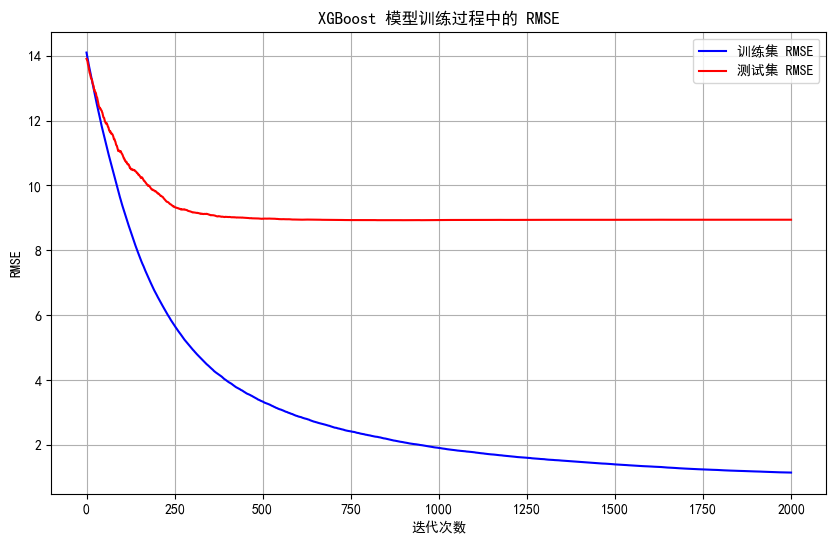

In [12]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:198.56696


[500]	train-rmse:10.90211


[1000]	train-rmse:3.45194


[1500]	train-rmse:1.77220


[1999]	train-rmse:1.11873


全部数据 MSE: 2.1747, 全部数据 R²: 1.0


Gap between last actual value and first prediction: 47.63640419921876


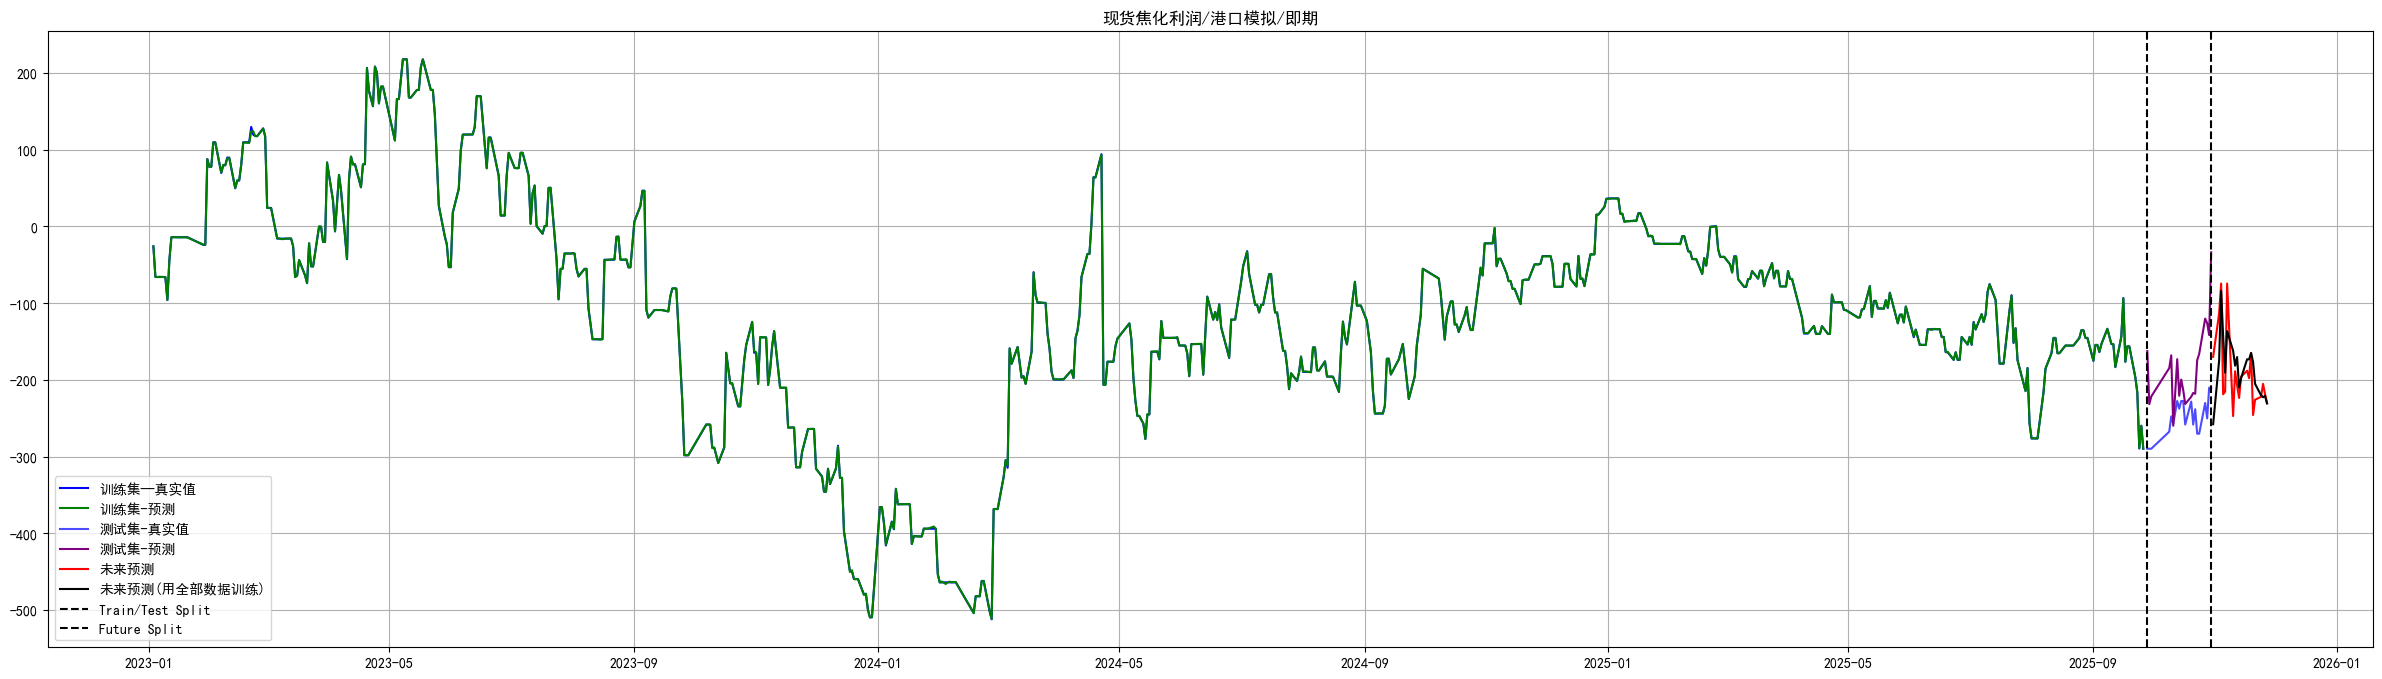

In [14]:

# 筛选2021年及以后的数据
start_date = pd.to_datetime('2023-01-01')
train_data_filtered = train_data[train_data['Date'] >= start_date]
y_train_filtered = y_train[train_data['Date'] >= start_date]
y_train_pred_filtered = y_train_pred_dmatrix[train_data['Date'] >= start_date]

# 使用移动平均进行平滑,窗口大小为3,center=True确保平滑后数据对齐
future_data['预测值_全量_平滑'] = future_data['预测值_全量'].rolling(window=2, center=True).mean()
future_data['预测值_全量_平滑'] = future_data['预测值_全量_平滑'].fillna(future_data['预测值_全量'])
future_data['预测值_全量'] = future_data['预测值_全量_平滑']
future_data = future_data.drop('预测值_全量_平滑', axis=1)

future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 重新绘制图表，只显示2021年及以后的数据
plt.figure(figsize=(30, 8))
plt.plot(train_data_filtered['Date'], y_train_filtered, label='训练集—真实值', color='blue')
plt.plot(train_data_filtered['Date'], y_train_pred_filtered, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('现货焦化利润/港口模拟/即期')
plt.legend()
plt.grid(True)
plt.show()

---

In [15]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/焦化厂利润_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
723,2025/11/27,NaN,-230.762543
722,2025/11/26,NaN,-220.993378
721,2025/11/25,NaN,-222.673759
720,2025/11/24,NaN,-220.056694
719,2025/11/21,NaN,-205.140984
...,...,...,...
4,2023/01/09,-65.8647,NaN
3,2023/01/06,-65.8647,NaN
2,2023/01/05,-65.8647,NaN
1,2023/01/04,-65.8647,NaN


In [16]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/焦化厂利润_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
34,2025/11/30,NaN,-180.909910
33,2025/10/31,-242.153929,-184.856227
32,2025/09/30,-191.971248,-180.888793
31,2025/08/31,-176.960295,-176.931303
30,2025/07/31,-146.018322,-146.020316


In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦炭_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "焦化厂利润"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.焦炭_数据上传.xlsx"
sheet_name = "详情页"
identifier = "焦化厂利润"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [19]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = '焦化厂利润',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'焦化厂利润\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'